# Homework 3
## Part 2
Start by running the functions from part 1, excluding all plots.

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import os
import itertools

In [2]:
imgs = []
dir_name = '6Images/'
list_of_files = sorted( filter( os.path.isfile,
                        glob.glob(dir_name + '*') ) )
# Iterate over sorted list of files and print the file paths 
# one by one.
for file_path in list_of_files:
    imgs.append(cv2.imread(file_path))


In [3]:
# image normalization
def normalizeImgs(imgs):
    normImgs = []
    for img in imgs:
        norm_img = np.zeros(img.shape[:2])
        final_img = cv2.normalize(img,norm_img,0,255,cv2.NORM_MINMAX)
        normImgs.append(final_img)
    return normImgs
    
normImgs = normalizeImgs(imgs)

In [5]:
def convertToGray(normImgs):
    grayImgs = []
    for img in normImgs:
        gr = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        grayImgs.append(gr)
    return grayImgs


In [6]:
def claheImages(imgs):
    clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    for img in imgs:
        clahe.apply(img) + 30
    return imgs

In [7]:
grayImgs = convertToGray(normImgs)
image_height, image_width = grayImgs[0].shape
camera_matrix = np.array([[1, 0, image_width/2],
                          [0, 1, image_height/2],
                          [0, 0, 1]])
#processedImgs = claheImages(grayImgs)


In [8]:
sift = cv2.xfeatures2d.SIFT_create(nfeatures=4000,nOctaveLayers=12,contrastThreshold=0.025,sigma=1.5)
#sift = cv2.xfeatures2d.SIFT_create()

In [9]:
def get_non_max_suppression_mask(keypoints):
    binary_image = np.zeros((image_height, image_width))
    response_list = np.array([keypoint.response for keypoint in keypoints])
    mask = np.flip(np.argsort(response_list))
    point_list = np.rint([keypoint.pt for keypoint in keypoints])[
        mask].astype(int)
    non_max_suppression_mask = []
    for point, index in zip(point_list, mask):
        if binary_image[point[1], point[0]] == 0:
            non_max_suppression_mask.append(index)
            cv2.circle(binary_image, (point[0], point[1]), 2, 255, -1)

    return non_max_suppression_mask

In [10]:
def featureDetector(sift_obj, grayImgs):
    kp = []
    des = []
    outImages = []
    for gr in grayImgs:
        k, d = sift_obj.detectAndCompute(gr,None)
        non_max_suppression_mask = get_non_max_suppression_mask(k) # source: ZZ
        outImage = cv2.drawKeypoints(gr, k, gr,color=[255,255,0],
                    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        
        #kps = np.array(k)[non_max_suppression_mask]
        #norm_keypoints(kps)
        #kp.append(kps)
        
        kp.append(np.array(k)[non_max_suppression_mask])
        des.append(np.array(d)[non_max_suppression_mask])
        outImages.append(outImage)
        
    return kp, des, outImages

In [11]:
kp, des, outImages = featureDetector(sift, grayImgs)

In [12]:
def knn_match_and_lowe_ratio_filter(matcher, des1, des2,threshold=0.90, dist_mask_12=None, draw_plot_dist=False):
    # First match 2 against 1
    if dist_mask_12 is None:
        dist_mask_21 = None
    else:
        dist_mask_21 = dist_mask_12.T
    matches_knn = matcher.knnMatch(des2,des1, k=2, mask = dist_mask_21 )
    all_ds = [m[0].distance for m in matches_knn if len(m) >0]

    #print("Len of knn matches", len(matches_knn))

    matches = []
    # Run lowes filter and filter with difference higher than threshold this might
    # still leave multiple matches into 1 (train descriptors)
    # Create mask of size des1 x des2 for permissible matches
    mask = np.zeros((des1.shape[0],des2.shape[0]),dtype='uint8')
    for match in matches_knn:
        if len(match)==1 or (len(match)>1 and match[0].distance < threshold*match[1].distance):
           # if match[0].distance < 75:
                matches.append(match[0])
                mask[match[0].trainIdx,match[0].queryIdx] = 1

    #matches = [m for m in matches if m.distance<5 ]

    if draw_plot_dist:
        fig, axes = plt.subplots(1, 1, num=3)
        filt_ds = [m.distance for m in matches]
        axes.plot(sorted(all_ds),'.',label = 'All Matches')
        axes.plot(sorted(filt_ds),'.',label = 'Filtered Matches')
        axes.set_xlabel('Number')
        axes.set_ylabel('Distance')
        axes.legend()
        plt.pause(.1)

    # run matches again using mask but from 1 to 2 which should remove duplicates
    # This is basically same as running cross match after lowe ratio test
    matches_cross = matcher.match(des1,des2,mask=mask)
    #print("Len of cross matches", len(matches_cross))
    return matches_cross

In [13]:
def getMatches(kp, des, onlyImagePair=False):
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches = []
    # kp_match is a list of tuples with kp_match[i] = (kp0_match, kp1_match)
    kp_match = [] 
    if onlyImagePair:
        matches.append(knn_match_and_lowe_ratio_filter(matcher,des[0],des[1],threshold=0.90))
        kp0_match_pts = np.array([kp[0][mat.queryIdx].pt for mat in matches[0]])
        kp1_match_pts = np.array([kp[1][mat.trainIdx].pt for mat in matches[0]])
        kp_match.append((kp0_match_pts,kp1_match_pts))
    else:
        # do sequential matching
        for i in range(6):
            if i < 5:
                # match with next pair
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[i+1],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[i+1][mat.trainIdx].pt for mat in matches[i]])
            else:
                # if i is at last image index, match the last image with the first image (6-1)
                matches.append(knn_match_and_lowe_ratio_filter(matcher,des[i],des[0],threshold=0.90))
                kp0_match_pts = np.array([kp[i][mat.queryIdx].pt for mat in matches[i]])
                kp1_match_pts = np.array([kp[0][mat.trainIdx].pt for mat in matches[i]])


            kp_match.append((kp0_match_pts,kp1_match_pts))
    return matches, kp_match

In [14]:
matches, kp_match = getMatches(kp,des)

In [15]:
def getInliers(kp, des, matches, kp_match):
    # use findFundamentalMatrix function to do RANSAC and assemble an inlier list
    mask_e = []
    kp_match_inliers = []
    i = 0
    for k_match in kp_match:
        F, maskMatch = cv2.findFundamentalMat(k_match[0], k_match[1],
                                             method=cv2.FM_RANSAC,       
                                             ransacReprojThreshold=1.0,
                                             confidence=0.9999)
        mask_e.append(maskMatch)
        
        kp0_match_inliers = [kp[i][mat.queryIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
        if i < 5:
            kp1_match_inliers = [kp[i+1][mat.trainIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
        else:
            kp1_match_inliers = [kp[0][mat.trainIdx] for mat, msk in zip(matches[i], mask_e[i]) if msk]
            
        kp_match_inliers.append((kp0_match_inliers,kp1_match_inliers))
        i+=1
        
    return kp_match_inliers, mask_e

In [16]:
kp_match_inliers, mask_e = getInliers(kp, des, matches, kp_match)

In [17]:
# returns a list of homographies for each image pair of keypoints given
# the homographies map the left image (src) to the right image (dst)
# UPDATE 27FEB:
# declare pts_left_src and pts_right_dst as global variables so that I can utilize them later
pts_left_src = []
pts_right_dst = []
def getHomography(kp_match_inliers, inliers = True):
    global pts_left_src
    global pts_right_dst
    pts_left_src = []
    pts_right_dst = []
    h = []
    mask = []
    if inliers:
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp_match[0][i].pt for i in range(len(kp_match[0]))]))
            #print(pts_left_src)
            pts_right_dst.append(np.float32([kp_match[1][i].pt for i in range(len(kp_match[1]))]))
    else:
        # if inliers were not already given to the homography function, get points and do RANSAC
        for kp_match in kp_match_inliers:
            pts_left_src.append(np.float32([kp_match[0][i] for i in range(len(kp_match[0]))]))
            #print(pts_left_src)
            pts_right_dst.append(np.float32([kp_match[1][i] for i in range(len(kp_match[1]))]))
    
    # this is only for the last run
    for i in range(len(pts_left_src)):
        if inliers:
            # switched these 19FEB
            h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i])
            #h_img, mask_img = cv2.findHomography(pts_left_src[i],pts_right_dst[i])
        else:
            h_img, mask_img = cv2.findHomography(pts_right_dst[i],pts_left_src[i],cv2.RANSAC,1.0)
            #h_img, mask_img = cv2.findHomography(pts_left_src[i],pts_right_dst[i],cv2.RANSAC,1.0)
        h.append(h_img)
        mask.append(mask_img)
    return h, mask

In [18]:
#h = getHomography(kp_match_inliers)
#print(kp_match[0][0])
# 1's in the mask are inliers
h, mask = getHomography(kp_match, inliers=False)
print(np.count_nonzero(mask[5]))


16


In [19]:
def alpha_blending(img1, img2):
    mask1 = cv2.inRange(img1,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask2 = cv2.inRange(img2,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask1 = cv2.bitwise_not(mask1)
    mask2 = cv2.bitwise_not(mask2)
    mask = cv2.bitwise_and(mask1, mask2)
    mask_inv = cv2.bitwise_not(mask)
    img1_fg = cv2.bitwise_and(img1,img1,mask = mask)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    img_fg = cv2.addWeighted(img1_fg,0.7,img2_fg,0.3,0)
    img1_bg = cv2.bitwise_and(img1,img1,mask = cv2.bitwise_and(mask1,mask_inv))
    img2_bg = cv2.bitwise_and(img2,img2,mask = cv2.bitwise_and(mask2,mask_inv))
    img = cv2.add(img2_bg,img1_bg)
    img = cv2.add(img,img_fg)
    return img


In [20]:
def alpha_blending_gray(img1, img2):
    mask1 = cv2.inRange(img1,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask2 = cv2.inRange(img2,np.array([0, 0, 0]),np.array([5, 5, 5]))
    mask1 = cv2.bitwise_not(mask1)
    mask2 = cv2.bitwise_not(mask2)
    mask = cv2.bitwise_and(mask1, mask2)
    mask_inv = cv2.bitwise_not(mask)
    img1_fg = cv2.bitwise_and(img1,img1,mask = mask)
    img2_fg = cv2.bitwise_and(img2,img2,mask = mask)
    img_fg = cv2.addWeighted(img1_fg,0.7,img2_fg,0.3,0)
    img1_bg = cv2.bitwise_and(img1,img1,mask = cv2.bitwise_and(mask1,mask_inv))
    img2_bg = cv2.bitwise_and(img2,img2,mask = cv2.bitwise_and(mask2,mask_inv))
    img = cv2.add(img2_bg,img1_bg)
    img = cv2.add(img,img_fg)
    return img

In [21]:
def warpTwoImages(img1, img2, H):
    '''warp img2 to img1 with homograph H'''
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    pts1 = np.float32([[[0,0],[0,h1],[w1,h1],[w1,0]]]).reshape(-1,1,2)
    pts2 = np.float32([[[0,0],[0,h2],[w2,h2],[w2,0]]]).reshape(-1,1,2)
    pts2_ = cv2.perspectiveTransform(pts2, H)
    pts = np.concatenate((pts1, pts2_), axis=0)
    [xmin, ymin] = np.int32(pts.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(pts.max(axis=0).ravel() + 0.5)
    t = [-xmin,-ymin]
    shift = pts2_[0][0]
    Ht = np.asarray([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
    result = cv2.warpPerspective(img2, Ht.dot(H), (xmax-xmin, ymax-ymin))
    H_t = np.dot(np.eye(3),np.asarray([[1,0,t[0]],[0,1,t[1]],[0,0,1]]))
    tmp = cv2.warpPerspective(img1, H_t, (xmax-xmin, ymax-ymin))
    output = alpha_blending(result,tmp)
    return output,t

In [22]:
#h = getHomography(kp_match_inliers)
h, mask = getHomography(kp_match, inliers=False)
def buildMosaic(h, normImgs):
    t = [0,0]
    #mosaicImgs = []
    for i in range(len(h)-1):
        #print(t)
        #print(h[i])
        h[i][0][2] += t[0]
        h[i][1][2] += t[1]
        if i != 0:
            h[i] = np.dot(h[i],h[i-1])
            
        if i == 0:
            mosaicImg, t = warpTwoImages(normImgs[i],normImgs[i+1],h[i])

        elif i > 0 and i < (len(h)): #len(h) or len(h) - 1?
            mosaicImg, t = warpTwoImages(mosaicImg,normImgs[i+1],h[i])

        else:
            mosaicImg, t = warpTwoImages(mosaicImg,normImgs[0],h[i])
    
    return mosaicImg

mosaicImg = buildMosaic(h, normImgs)
#plt.figure(figsize = (12,12))
#plt.imshow(mosaicImg)

checkNewImageArea is a new function I use in part 2 to help further test if the homography is good or not. If four image points change in area by a factor greater than 1.25, then I know that the homography is bad because there is too much warping.

I compute the area of the polygon using the Shoelace formula from [this implementation](https://stackoverflow.com/questions/41077185/fastest-way-to-shoelace-formula).

In [23]:
def shoelaceArea(x_y):
    x_y = np.array(x_y)
    x_y = x_y.reshape(-1,2)

    x = x_y[:,0]
    y = x_y[:,1]

    S1 = np.sum(x*np.roll(y,-1))
    S2 = np.sum(y*np.roll(x,-1))

    area = .5*np.absolute(S1 - S2)

    return area

In [24]:
def checkNewImageArea(h):
    # homogenous image dimension points
    originalPoints = np.array([[0,0,1],
                               [image_width,0,1],
                               [image_width-1,image_height,1],
                               [0,image_height,1]])
    
    transformedPts = np.zeros((4,2))
    i = 0
    for pts in originalPoints:
        newPts = np.matmul(h,pts)
        transformedPts[i] = newPts[:2]
        i+=1
        
    originalArea = shoelaceArea(originalPoints[:,:2])
    warpedArea = shoelaceArea(transformedPts)
    areaRatio = warpedArea / originalArea
    if areaRatio < 1.10 and areaRatio > 0.90:
        return True
    else: 
        return False

In [25]:
checkNewImageArea(h[0])

True

In [26]:
def isHomographyGood(h):
    hR = h[0:2,0:2]
    #if np.linalg.det(hR) > 0 and checkNewImageArea(h):
    if np.linalg.det(hR) > 0:
        return True
    else:
        return False

In [27]:
# do image pair 1-6
# create function that does this between two images easily.
def registerTwoImages(imgList,index1,index2,kp,des):
    gray16 = [imgList[index1], imgList[index2]]
    kp16 = [kp[index1],kp[index2]]
    des16 = [des[index1],des[index2]]
    match, kp_match = getMatches(kp16,des16, onlyImagePair=True)
    kp_match_inliers, mask_e = getInliers(kp16, des16, match, kp_match)
    
    #matchImgs = drawInliers(gray16,match,kp_match_inliers,mask_e)
    h, mask = getHomography(kp_match, inliers=False)
    #print(isHomographyGood(h[0]))
    result,t  = warpTwoImages(normImgs[index2],normImgs[index1],h[0])
    #return result
    
    return h, mask

#result16 = registerTwoImages(grayImgs,0,5,kp,des)
#plt.imshow(result16)

## Part 2 Start
Go around the entire loop of 6 images and set up the problem by outputting vertices and edges in terms of a factor graph. Images that you manage to register in part (b) above can be thought of as loop closure events. 

Start by importing gtsam and g2o. Currently, I do not plan on using g2o, but I imported it just in case.

In [28]:
import g2o
import gtsam
import gtsam.utils.plot

Create a noise model for the covariance matrix. For this project, I will create a diagonal covariance matrix (no cross covariances) by using the number of matching inlier points that an image has. I will assign an error value for x, y, and theta, with more matches equal to less error. 

The covariance matrix will by a 3x3 matrix as shown below:

<center>$ cov = \begin{bmatrix} x_{err} & 0 & 0 \\ 0 & y_{err} & 0 \\ 0 & 0 & \theta_{err} \end{bmatrix}$</center><br>

In [29]:
def getOdometryNoise(mask):
    numMatches = np.count_nonzero(mask)
    # define error lists in the form of [xerr,yerr,theta_err]
    minError = [0.2, 0.2, 0.1]
    smallError = [0.5, 0.5, 0.25]
    largeError = [0.8, 0.8, 0.4]
    maxError = [1.0, 1.0, 0.5]
    
    if numMatches > 100:
        err = minError
    elif numMatches > 50 and numMatches <= 100:
        err = smallError
    elif numMatches > 20 and numMatches <= 50:
        err = largeError
    else:
        # less than 20 inlier matches
        err = maxError
    
    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(err[0], err[1], err[2]))

Let's run GTSAM! First, define the start point (prior factor) and initialize the graph. 

In [30]:
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
graph = gtsam.NonlinearFactorGraph()

# add a prior on the first pose at origin (image 0 center)
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(image_width/2, image_height/2, 0), PRIOR_NOISE))

Define a function that gets the factor poses or observations between the images. This is done by getting the similarity matrix (partial affine matrix) between matching points and extracting the x, y, and theta from that matrix. This idea originated from ZZ.

In [31]:
ransac_mask = []
def getFactorPose(index, pts_src = pts_left_src, pts_dst = pts_right_dst):
    global ransac_mask
    #if len(pts_src) > 4:
        # pts_src and pts_dst do not need to be iterated through
        # keep src/dst order consistent
    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
    similarity_mat[:2, :2] /= scale
    affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))
    # NOTE: INVERTED ON 01MAR
    #affine_matrix = np.linalg.inv(affine_matrix)
    #print(affine_matrix)
    return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
    #else:
        # return gtsam version of None
        #return None # TODO: Check this
        
getFactorPose(0)

(-5.85949, 132.571, -0.022727)

Add initial estimates to the solution first. My initial estimates are the image homographies solved for from part 1. 

In [32]:
def extractHomographyPose(h):
    affineEst = h
    affineEst[2][0] = 0
    affineEst[2][1] = 0
    #print(affineEst)
    scale = np.sqrt(affineEst[0,0]**2+affineEst[1,0]**2) # adapted from ZZ
    affineEst[:2, :2] /= scale
    rot = affineEst[:2, :2]
    total_affine_matrix = np.eye(3)

    affineEst_inv = np.linalg.inv(affineEst)
    affineEst = affineEst_inv.dot(total_affine_matrix)
    return gtsam.Pose2(affineEst[0, -1], affineEst[1, -1],
                    np.arctan2(affineEst[1, 0], affineEst[0, 0]))

In [33]:
def initialEstimates(h):
    initial_estimate = gtsam.Values()
    initial_estimate.insert(0, gtsam.Pose2())
    
    for i in range(len(h)-1):
        initial_estimate.insert(i+1, extractHomographyPose(h[i]))
        
    return initial_estimate

initial = initialEstimates(h)

Plot graph function is taken from ZZ's code.

In [34]:
def plot_graph(values, graph, marginals):

    for vertex_index in range(values.size()):
        gtsam.utils.plot.plot_pose2(0, values.atPose2(
            vertex_index), 0.5, marginals.marginalCovariance(vertex_index))

    for edge_index in range(graph.size())[1:]:
        key1, key2 = graph.at(edge_index).keys()

        start_pose = values.atPose2(key1)
        end_pose = values.atPose2(key2)
        plt.plot([start_pose.x(), end_pose.x()],
                 [start_pose.y(), end_pose.y()],
                 color='blue')

    plt.show()

Now it is time to build the graph! To build the graph, I liked ZZ's loop that he used with itertools because it iterates through all the images successfully while also checking for loop closures on non-successive images. I will use a similar function in order to connect the between-factor poses.

### Update: I seperated the loop into two parts, that way I can illustrate the factor graph before adding loop closures

In [35]:
# nonlinear graph initialization done earlier
for src_index, dst_index in itertools.combinations(range(len(normImgs)), 2):
    
    if src_index + 1 == dst_index:
        graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                               getFactorPose(src_index), getOdometryNoise(mask[src_index])))

Plot graph before optimization and without loop closures. Notice how the fourth vertex is in the wrong location.

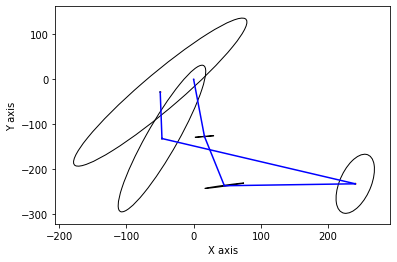

In [36]:
#graph = build_graph(initial)
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

Check for loop closures:

In [37]:
for src_index, dst_index in itertools.combinations(range(len(normImgs)), 2):
    if src_index + 1 != dst_index:
        homog, maskIm = registerTwoImages(normImgs,src_index,dst_index,kp,des)
        if isHomographyGood(homog[0]):
            
            kpList = [kp[src_index],kp[dst_index]]
            desList = [des[src_index],des[dst_index]]
            match_overlap, kp_match_overlap = getMatches(kpList,desList, onlyImagePair=True)

            pts_left_overlap = []
            pts_right_overlap = []
            for kp_matches in kp_match_overlap:
                pts_left_overlap.append(np.float32([kp_matches[0][i] for i in range(len(kp_matches[0]))]))
                #print(pts_left_src)
                pts_right_overlap.append(np.float32([kp_matches[1][i] for i in range(len(kp_matches[1]))]))

            factor_pose = getFactorPose(0, pts_left_overlap, pts_right_overlap)
            if factor_pose is not None:
                graph.add(gtsam.BetweenFactorPose2(src_index, dst_index,
                                    factor_pose, getOdometryNoise(ransac_mask)))

Plot graph after optimization and loop closures. Notice how the covariances get much smaller after loop closure and optimization.

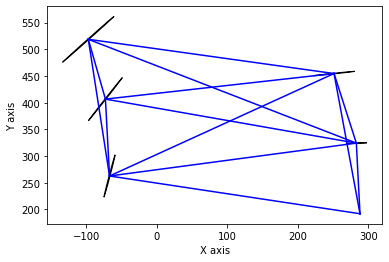

In [38]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial, params)
initial = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial)
plot_graph(initial, graph, marginals)

Extract the optimized, affine matrices from the factor graph. Source: ZZ

In [39]:
def extractAffineMatrixList(initial, image_list):
    poses = gtsam.utilities.allPose2s(initial)
    affine_matrix_list = []

    for index in range(len(image_list)):

        pose = poses.atPose2(index)
        #print(pose)
        #pose = [x * -1 for x in pose]
        affine_matrix = pose.matrix()
        #affine_matrix = np.linalg.inv(affine_matrix)
        translation_matrix = np.eye(3)

        translation_matrix[:2, 2] -= np.array([image_width/2, image_height/2]).T
        #print(affine_matrix.dot(translation_matrix))
        #affine_matrix_list.append(affine_matrix)
        affine_matrix_list.append(affine_matrix.dot(translation_matrix))
    
    #print(affine_matrix_list[0])
    affine_matrix_list.reverse()
    return affine_matrix_list

In [40]:
affine_matrix_list = extractAffineMatrixList(initial, normImgs)

I attempted to use my buildMosaic function from part 1, but it was unsuccessful in correctly stitching the images. I ended up using ZZ's to stitch; however, I added my alpha blending function from part 1 to better combine the images.

In [41]:
def get_warp_point(homography_matrix, point):
    warp_point = homography_matrix.dot(np.append(point, [1]).T)
    return (warp_point / warp_point[-1])[:2]

In [42]:
def get_stitch_image_size_offset_affine_matrix(homography_matrix_list):
    corner_point_list = []

    for homography_matrix in homography_matrix_list:

        corner_point_list.append(get_warp_point(
            homography_matrix, [0, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, 0]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [image_width - 1, image_height - 1]))
        corner_point_list.append(get_warp_point(
            homography_matrix, [0, image_height - 1]))

    min_point = (np.floor(np.amin(corner_point_list, axis=0))).astype(np.int32)
    max_point = (np.ceil(np.amax(corner_point_list, axis=0))).astype(np.int32)

    stitch_image_size = tuple(max_point - min_point + 1)

    offset_affine_matrix = np.eye(3, dtype=np.float64)
    if min_point[0] < 0:
        offset_affine_matrix[0, -1] -= min_point[0]
    if min_point[1] < 0:
        offset_affine_matrix[1, -1] -= min_point[1]
    return stitch_image_size, offset_affine_matrix

In [43]:
def get_stitch_image(homography_matrix_list, image_list, stitch_image_size, offset_affine_matrix):

    stitch_image = np.zeros(
        (stitch_image_size[1], stitch_image_size[0], 3), np.uint8)
    print(stitch_image.shape)
    image_list.reverse()
    for homography_matrix, image in zip(homography_matrix_list, image_list):
        
        warp_image = cv2.warpPerspective(
            image, offset_affine_matrix.dot(homography_matrix), stitch_image_size)
        #plt.imshow(warp_image)
        #break
        warp_image_mask = (warp_image != 0)
        stitch_image[warp_image_mask] = warp_image[warp_image_mask]
        
        
        output = alpha_blending(stitch_image,warp_image)
    

    return output

(739, 989, 3)


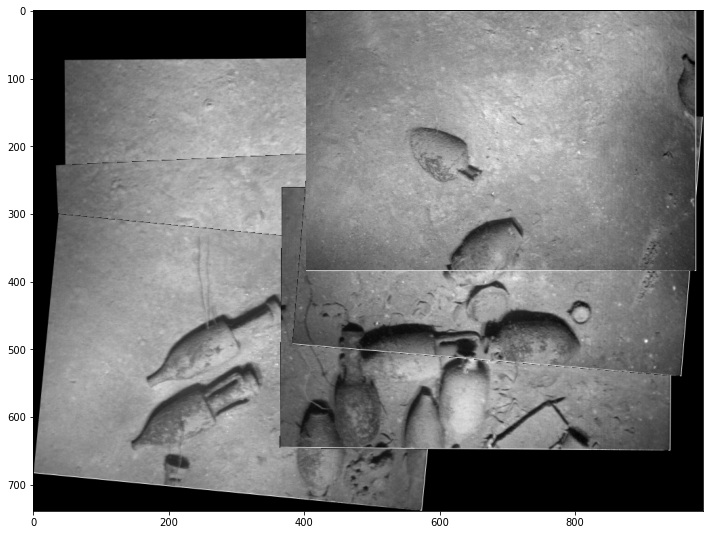

In [44]:
stitch_image_size, offset_affine_matrix = get_stitch_image_size_offset_affine_matrix(
    affine_matrix_list)

stitch_image = get_stitch_image(
    affine_matrix_list, normImgs, stitch_image_size, offset_affine_matrix)

plt.figure(figsize = (12,12))
plt.imshow(stitch_image)
plt.show()